# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** W

**Names:**

* Olivier Cloux
* Thibault Urien
* Saskia Reiss

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics


#### Exercise 2.9: Simulate an epidemic outbreak

In [1]:
# Imports
import epidemics_helper
import requests
import networkx as nx
import numpy as np
from networkx.readwrite import json_graph
import json
import matplotlib.pyplot as plt

In [2]:
with open('../data/nyc_augmented_network.json') as data_file:
    data = json.load(data_file)
    g = json_graph.node_link_graph(data)
    sir = epidemics_helper.SimulationSIR(g, beta=10.0, gamma=0.1)
    sir.launch_epidemic(23654,100)

Epidemic stopped after 101.15 days | 101.15 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered


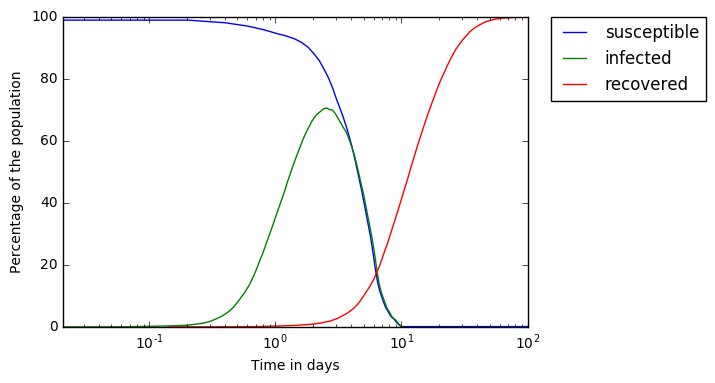

In [3]:
def plotSIR(simu):
    sortedS = list(sorted(map( lambda x : min(x, simu.max_time),simu.inf_time)))
    valuesS, baseS = np.histogram(sortedS, bins=500)

    sortedI = list(filter(lambda x : x < simu.max_time,sortedS))
    valuesI, baseI = np.histogram(sortedI, bins=500)

    sortedR = list(sorted(filter( lambda x : x <= simu.max_time,simu.rec_time)))
    valuesR, baseR = np.histogram(sortedR, bins=500)

    #evaluate the cumulative
    cumulativeS = np.cumsum(valuesS)
    cumulativeI = np.cumsum(valuesI)
    cumulativeR = np.cumsum(valuesR)

    # plot the cumulative function
    plt.plot(baseS[:-1], (len(sortedS)-cumulativeS)/len(sortedS) *100, c='blue', label="susceptible")
    #plot the survival function
    plt.plot(baseI[:-1],(cumulativeR-cumulativeI)/len(sortedS) *100, c='green',label="infected")

    plt.plot(baseR[:-1], (cumulativeR)/len(sortedS) *100, c='red',label="recovered")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("Time in days")
    plt.ylabel("Percentage of the population")
    plt.xscale("log")
    plt.ylim([0, 100])
    plt.xlim([0, simu.max_time])
    plt.show();
    
plotSIR(sir)

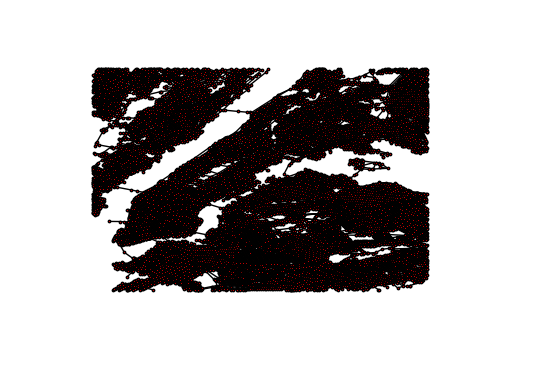

In [7]:
plt.axis('off')
fig = plt.figure(1)
positions = nx.get_node_attributes(g,'coordinates')
nx.draw(g,positions,node_size=3)
plt.figure(100,figsize=(100,100)) 
plt.show();

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [4]:
i = 0
rem_edges = [] 
connected = [to for (fr, to) in g.edges(node)]  

for i in range(0, 999):
    remove = random.choice(connected)  
    conected.remove(remove)
    rem_edges += [remove]
g.remove_edges_from(remove)

NameError: name 'node' is not defined

#### Exercise 2.11: Strategy 2